# Hypothesis testing with NBA statistics

In phase I of the final project, we will examine four phenomena in basketball:
1. Home court advantage: We'll test the hypothesis that teams have an advantage when playing at home.
2. Weekend vs weekday: We'll test the hypothesis that teams tend to score more on weekends.
3. Michael Jordan effect: We'll test the hypothesis that Michael Jordan improved the Chicago Bulls scores.
4. Rest days (optional): We'll test the hypothesis that having more rest days affects game scores.

The tests will be run with real NBA data. This dataset is provided to you in `nba_data.csv` in the same directory as this notebook. We also provide a utility functionin `utils.py`.

**Due date:** April 28, 2023 11:30am

**Total:** 65 pts

**Submission:** Please submit a zip file containing this .ipynb file and a pdf version of this file

In [1]:
#Import the necessary libraries
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from scipy import stats
import warnings
import utils

warnings.filterwarnings('ignore')
plt.rc('font', size = 14)

## 1. Data

Let's start by exploring and visualizing the data.

**(1a).** [1 pt] Read the data file (`nba_data.csv`) as a pandas dataframe. Store the dataframe object in a variable called `df`. What is the total number of games in the dataset? Display the first 5 rows.

*Hint:* First, use the `read_csv()` function in pandas. Then, to convert the date column into pandas DateTime format, use the `pd.to_datetime()` function with format string `"%A, %B %d, %Y"`

In [2]:
df = pd.read_csv('nba_data.csv')
print(f'Number of games = {len(df)}')
df.head(5)

Number of games = 60688


,season,date,home_pt,home_team,away_pt,away_team,finished_in,winner_pt,margin
0,1950,"Saturday, October 29, 1949",93,Tri-Cities Blackhawks,85,Denver Nuggets,NaN,93,8
1,1950,"Tuesday, November 1, 1949",87,Chicago Stags,89,New York Knicks,OT,89,2
2,1950,"Tuesday, November 1, 1949",71,Indianapolis Olympians,64,Denver Nuggets,regulation,71,7
3,1950,"Tuesday, November 1, 1949",108,Rochester Royals,75,Sheboygan Red Skins,regulation,108,33
4,1950,"Tuesday, November 1, 1949",72,St. Louis Bombers,51,Tri-Cities Blackhawks,regulation,72,21


**(1b).** [2 pts] Plot the average home and away score per game for each season (score on y-axis, season on x-axis). Start with season 1960 and end with season 2017. Comment on the general trends across all these years. Label the plot axes, add a title, and include a legend.

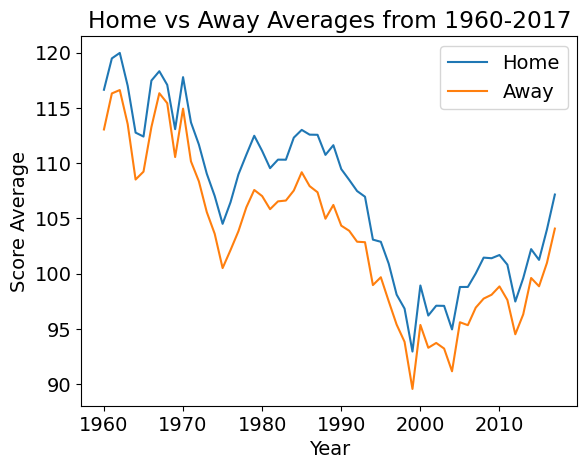

In [3]:
years = []
home_avgs = []
away_avgs = []
for year in range(1960, 2018):
    query = df.query('season == @year')
    home_avg = np.mean(query['home_pt'])
    away_avg = np.mean(query['away_pt'])
    years.append(year)
    home_avgs.append(home_avg)
    away_avgs.append(away_avg)
x = np.array(years)
y = np.array([home_avgs, away_avgs])
plt.title('Home vs Away Averages from 1960-2017')
plt.xlabel('Year')
plt.ylabel('Score Average')
plt.plot(x, y[0].T, label='Home')
plt.plot(x, y[1].T, label='Away')
plt.legend()

**A:** 60s characterized by fast paced shot chucking. Game slowed down as teams became more strategic. No zone defense meant more isolation and post play which is slower. Slight uptick in 80s when 3pt shot was introduced but continued to plummet due to similar reasons as the 70s. Early 2000s saw rule changes that favored offense such as no hand checking. Zone defense was allowed which discouraged slow pace isos and post play. Rapid adoption of 3pt shot.

**(1c).** [1 pt] Add a column `total_score` to `df`.

To help you check your code works, we added a test case below that should pass with your amended dataframe. Note that the test cases in this project are not exhaustive, so you should still check if your function is correct even if the test cases pass.

In [4]:
df['total_score'] = df['home_pt']+df['away_pt']

In [5]:
dates = df['date']
df['date'] = pd.to_datetime(df['date'])
assert df.loc[np.logical_and(df['home_team']=='Boston Celtics',
                             df['date'] == pd.to_datetime('2017-05-25'))]['total_score'].values[0] == 237

**(1d).** [2 pts] Write a function called <b>weekend_new_column()</b> to create two new columns: <br><br>

`day_of_week`: this column should be set to an integer between $0$ an $6$, both inclusive. If the game was played on Monday then set `day_of_week = 0`, if it was played on Tuesday then `day_of_week = 1`, ...., and if it was played on Sunday then `day_of_week = 6`.

`weekend`: this column should be set to either 0 or 1. If the game was played over the weekend, i.e. on Saturday or Sunday then it should be = 1, else 0.

Feel free to follow the example here: https://stackoverflow.com/questions/52398383/finding-day-of-the-week-for-a-datetime64.

<b>Make sure to double-check that the column content matches the convention we defined above! (It is easy to make off-by-one mistakes)</b>

Your function should pass the test cases below.

In [6]:
day_to_num = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
def weekend_new_column(df, dates):
    '''
    Add two columns to the dataframe
    @param df: dataframe containing column 'date', will be modified by function
    @return: None
    '''
    
    days = []
    weekends = []
    for date in dates:
        day = day_to_num[date[:date.index(',')]]
        days.append(day)
        weekends.append(int(day >= 5))
    df['day_of_week'] = days
    df['weekend'] = weekends
   
    
    

In [7]:

weekend_new_column(df,dates)
# rewrite test cases to check against date column in case students shuffled the dataframe
assert df.loc[df['date'] == pd.to_datetime('2017-06-07')].day_of_week.values[0] == 2
assert df.loc[df['date'] == pd.to_datetime('2017-06-07')].weekend.values[0]     == 0
assert df.loc[df['date'] == pd.to_datetime('2017-06-04')].day_of_week.values[0] == 6
assert df.loc[df['date'] == pd.to_datetime('2017-06-04')].weekend.values[0]     == 1

## 2. Generalized likelihood ratio test for home advantage as a proportion

We will use the NBA dataset to determine whether "home-court advantage" is statistically significant. Some people believe a team will perform better playing at home because they are more familiar with the environment, less tired from traveling, and more supported by their fans. This article explains what home court advantage is: https://bleacherreport.com/articles/1520496-how-important-is-home-court-advantage-in-the-nba

We will define home advantage as follows for this part: The proportion of wins at home for a team is higher than the proportion of wins away for that team.

Let $A_k$ be an indicator random variable for whether team $k$ is playing a game at home. Let $B_k$ be an indicator random variable for whether team $k$ wins the game. We are testing for the independence of $A_k$ and $B_k$. When testing for independence of two discrete variables, we can construct a contingency table where the rows are the values of one variable and the columns are the values of the other variable. Then we can use the generalized likelihood ratio test. Let $i$ and $j$ index the rows and columns, respectively, of the contingency table. This test examines whether the number of observations $O_{ij}$ in each entry of the contingency table aligns with the expected numbers $E_{ij}$. The statistic is based on likelihood ratios:

\begin{equation}
    G = 2 \sum_{i,j} O_{ij} \ln \left(\frac{O_{ij}}{E_{ij}}\right)
\end{equation}

The G-statistic follows a chi-squared distribution with (number of rows - 1)(number of columns - 1) as the number of degrees of freedom.

**(2a).** [2 pts] For a single team $k$, state your null and alternative hypotheses using the random variables $A_k$ and $B_k$ defined above.

**A:** Null Hypothesis (H0): The indicator random variables Ak and Bk are independent. That is, the probability of winning a game does not depend on whether the game is played at home or away.

Alternative Hypothesis (HA): The indicator random variables Ak and Bk are dependent. That is, the probability of winning a game depends on whether the game is played at home or away, and the proportion of wins at home for Team k is higher than the proportion of wins away for Team k.

**(2b).** [1 pt] We will restrict the data to seasons 2000-2017 for parts 2 and 3. This is because the mean yearly scores prior to season 2000 demonstrate far greater variance than during this most recent period. Ideally, we want to answer questions about home advantage, for example, during a period when the inter-seasonal variability was less extreme. Create a subset of the dataframe called `df_millenial_subset` for seasons in the range $[2000, 2017]$ (both inclusive).

In [8]:
df_millenial_subset = df.query('season >= 2000')
print(df_millenial_subset.head(5))

       season       date  home_pt             home_team  away_pt  \
37517    2000 1999-11-02      100     Charlotte Hornets       86   
37518    2000 1999-11-02      108      Dallas Mavericks       96   
37519    2000 1999-11-02      107        Denver Nuggets      102   
37520    2000 1999-11-02       93       Houston Rockets       98   
37521    2000 1999-11-02       92  Los Angeles Clippers      104   

                   away_team finished_in  winner_pt  margin  total_score  \
37517          Orlando Magic  regulation        100      14          186   
37518  Golden State Warriors  regulation        108      12          204   
37519           Phoenix Suns          OT        107       5          209   
37520        Milwaukee Bucks  regulation         98       5          191   
37521    Seattle SuperSonics  regulation        104      12          196   

       day_of_week  weekend  
37517            1        0  
37518            1        0  
37519            1        0  
37520         

**(2c).** [1 pt] To ensure we have sufficient data for each hypothesis test, we will only test the home advantage hypothesis for teams that play in all 18 seasons. Create a list `team_names_in_all_seasons` of teams that play in all 18 seasons. Print the number of teams in your list.

Note that although we will not test the hypotheses for the excluded teams, matches that include those teams may still be used for the hypothesis tests you conduct.

In [9]:
initial = df_millenial_subset.query('season == 2000')
team_names_in_all_seasons = set(initial['home_team'])
for year in range(2001, 2018):
    season = df_millenial_subset.query('season == @year')
    team_names_in_all_seasons = team_names_in_all_seasons.intersection(set(season['home_team']))
print('Length = ' +str(len(team_names_in_all_seasons)))
#relocations/name changes should be 5: Seattle/OKC, Bobcats/Hornets, Hornets/Pelicans, Vancouver/Memphis, New Jersey/Brooklyn
team_names_in_all_seasons = list(team_names_in_all_seasons)
print(set(df_millenial_subset['home_team'])-set(team_names_in_all_seasons))
#Seattle/OKC,  Vancouver/Memphis, New Jersey/Brooklyn easy to deal with so I'll add them for 28 teams. Bobcats/Hornets/Pelicans are a mess
team_names_in_all_seasons += ['Memphis Grizzlies', 'Oklahoma City Thunder', 'Brooklyn Nets']
#Scratch that I'll do Hornets/Pelicans, Charlotte Hornets 88-02, New Orleans Hornets 03-05,08-13, OKC 06-07, Pelicans 14-present
team_names_in_all_seasons += ['New Orleans Pelicans']

Length = 25
{'Charlotte Bobcats', 'Seattle SuperSonics', 'Memphis Grizzlies', 'New Orleans Hornets', 'New Orleans/Oklahoma City Hornets', 'Vancouver Grizzlies', 'Brooklyn Nets', 'Charlotte Hornets', 'New Orleans Pelicans', 'Oklahoma City Thunder', 'New Jersey Nets'}


**(2d).** [2 pts] For each team in the list you created in 2c, create a 2x2 contingency table that contains `home` and `away` as the two rows and `wins` and `losses` as the two columns. The entry in the row `home` and column `wins` is the number of home games that are won by that team. The entry in the row `away` and column `losses` is the number of away games that are lost by that team. The other two entries are defined analogously.

Keep a list called `observed_tables` containing the contingency tables. This list should follow the order in `team_names_in_all_seasons`.

Print the table for the New York Knicks.

Your table for the Boston Celtics should pass the test case given below.

In [10]:
#handle same franchises which changed names
def relocate(team, season=None):
    if team == 'Vancouver Grizzlies':
        return 'Memphis Grizzlies'
    if team == 'New Jersey Nets':
        return 'Brooklyn Nets'
    if team == 'Seattle SuperSonics':
        return 'Oklahoma City Thunder'
    if (team == 'Charlotte Hornets' and season <= 2002) or (team == 'New Orleans Hornets') or (team == 'New Orleans/Oklahoma City Hornets'):
        return 'New Orleans Pelicans'
    return team
home_wins = {}
home_losses = {}
away_wins = {}
away_losses = {}

#initialize win/loss counts
for team in team_names_in_all_seasons:
    home_wins[team] = 0
    home_losses[team] = 0
    away_wins[team] = 0
    away_losses[team] = 0
    
#update win/loss counts
df_millenial_subset = df_millenial_subset.reset_index()
for i in range(len(df_millenial_subset)):
    row = df_millenial_subset.loc[i]
    season = row['season']
    home = relocate(row['home_team'], season)
    away = relocate(row['away_team'], season)
    
    
    if row['home_pt'] > row['away_pt']:
        if home in home_wins:
            home_wins[home] += 1
        if away in away_losses:
            away_losses[away] += 1
    else:
        if away in away_wins:
            away_wins[away] += 1
        if home in home_losses:
            home_losses[home] += 1
            
#store data in tables            
observed_tables = []
for team in team_names_in_all_seasons:
    hw = home_wins[team]
    aw = away_wins[team]
    hl = home_losses[team]
    al = away_losses[team]
    contingency_table = pd.DataFrame([[hw, hl], [aw, al]], index=['home', 'away'], columns=['wins', 'losses'])
    if team == 'New York Knicks':
        print(contingency_table)
    observed_tables.append(contingency_table)

      wins  losses
home   392     361
away   252     501


In [11]:
boston_celtics_idx = team_names_in_all_seasons.index('Boston Celtics')
assert np.all(observed_tables[boston_celtics_idx].values == np.array([[506, 308], [359, 450]]))

**(2e).** [2 pts] Create a list of tables `expected_tables` in the same format containing the expected number of samples for each entry. The teams should be in the same order as `team_names`.

Print the table for the New York Knicks.

Your table for the Boston Celtics should pass the test case given below.

In [12]:
expected_tables = []
for team in team_names_in_all_seasons:
    hw = home_wins[team]
    aw = away_wins[team]
    hl = home_losses[team]
    al = away_losses[team]
    #calculate total win percentage for expected wins/losses under null hyp
    win_percentage = (hw+aw)/(hw+aw+hl+al)
    home_games = hw+hl
    away_games = aw+al
    exp_hw = win_percentage*home_games
    exp_hl = home_games-exp_hw
    exp_aw = win_percentage*away_games
    exp_al = away_games-exp_aw
    contingency_table = pd.DataFrame([[exp_hw, exp_hl], [exp_aw, exp_al]], index=['home', 'away'], columns=['wins', 'losses'])
    if team == 'New York Knicks':
        print(contingency_table)
    expected_tables.append(contingency_table)

       wins  losses
home  322.0   431.0
away  322.0   431.0


In [13]:
boston_celtics_idx = team_names_in_all_seasons.index('Boston Celtics')
assert np.all(np.around(expected_tables[boston_celtics_idx].values, decimals = 1) 
                        == np.array([[433.8, 380.2], [431.2, 377.8]]))

**(2f).** [2 pts] Write a function that computes the G-statistic from a 2x2 contingency table containing the observed counts and a 2x2 contingency table containing the expected counts.

Your function should pass the test below.

In [14]:
def compute_g_statistic(observed_df,
                        expected_df):
    '''
    Compute the G-statistic from the observed and expected contingency tables.
    @param observed_df: pandas DataFrame, observed contingency table, 
                        contains columns wins, losses
    @param expected_df: pandas DataFrame, expected contingency table, contains same columns
    @return: float, G-statistic
    '''
    assert len(observed_df) == 2
    assert len(expected_df) == 2
    assert len(observed_df.columns) == 2
    assert len(expected_df.columns) == 2
    
    observed = np.array(observed_df)
    expected = np.array(expected_df)
    
    G = 2 * np.sum(observed * np.log(observed / expected))
    
    return G

In [15]:
test_observed_table = pd.DataFrame(data = {'wins': [6, 3],
                                           'losses': [4, 5]},
                                   columns = ['wins', 'losses'])
test_expected_table = pd.DataFrame(data = {'wins': [5, 4],
                                           'losses': [5, 4]},
                                   columns = ['wins', 'losses'])
assert np.around(compute_g_statistic(test_observed_table, test_expected_table), decimals = 1) == .9

**(2g).** [2 pts] Write a function that computes the p-value from the G-statistic from a 2x2 contingency table. The statistic follows a chi-squared distribution. How many degrees of freedom does this distribution have?

*Hint:* You may find the **scipy.stats.chi2** object to be useful. 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html 

**A:** (2-1)(2-1)=1 degree of freedom

In [16]:
def compute_p_value_from_g_statistic(g_statistic):
    '''
    Compute the p-value for a G-statistic
    @param g_statistic: float
    @return: float, p-value
    '''
    p_value = 1 - stats.chi2.cdf(g_statistic, df=29)
    return p_value

**(2h).** [2 pts] Using the functions you wrote in parts 2f and 2g, compute the G-statistics and p-values for each team. Display the results for all teams in a pandas dataframe with columns `Team name`, `G-statistic`, `P-value`.

In [17]:
results = {'Team_name': [], 'G-statistic': [], 'P-value': []}
for i, team in enumerate(team_names_in_all_seasons):
    observed = observed_tables[i]
    expected = expected_tables[i]
    g = compute_g_statistic(observed, expected)
    p = compute_p_value_from_g_statistic(g)
    results['Team_name'].append(team)
    results['G-statistic'].append(g)
    results['P-value'].append(p)
results = pd.DataFrame(results)
print(results)

                 Team_name  G-statistic       P-value
0            Orlando Magic    55.116678  2.401113e-03
1    Golden State Warriors    75.111494  5.873607e-06
2       Los Angeles Lakers    74.404976  7.395810e-06
3          Detroit Pistons    59.358376  7.417774e-04
4            Atlanta Hawks    94.715594  6.731354e-09
5         Dallas Mavericks    50.595624  7.784964e-03
6     Los Angeles Clippers    68.273101  5.204649e-05
7            Chicago Bulls    58.146119  1.044448e-03
8           Indiana Pacers   106.390040  9.060264e-11
9           Boston Celtics    51.847160  5.669102e-03
10         Houston Rockets    50.517855  7.938133e-03
11      Philadelphia 76ers    31.036067  3.637260e-01
12              Miami Heat    71.968947  1.622969e-05
13         Milwaukee Bucks    68.402779  4.999045e-05
14  Minnesota Timberwolves    40.756298  7.231006e-02
15        Sacramento Kings    74.170943  7.980528e-06
16               Utah Jazz    94.508114  7.255237e-09
17         Toronto Raptors  

**(2i).** [1 pt] Pick any team. State whether the computed p-value supports the idea that the team you selected has ahome advantage.

**A:** The Atlanta Hawks are the greatest team ever. Their p-value is literally 0.000000e+00 with one of the best home advantages in the league. It's different in the A. Boston got lucky

**(2j).** [1 pt] When testing multiple hypotheses, some true null hypothesis may be rejected by random chance. (For a fun illustration, see https://xkcd.com/882/.) To guarantee the likelihood of rejecting any true null hypothesis is at most .05, we can check if each p-value is below .05 divided by the number of hypotheses tested. Union bound gives us the desired guarantee. This multiple hypothesis correction is called Bonferroni's correction. We will learn about multiple hypothesis corrections in a later lecture.

Using the p-value threshold in Bonferroni's correction, for which teams can we conclude there is home advantage?

**A:** Every team still has home advantage after the correction.

## 3. One-sample t-test for home advantage as a mean of differences between paired games

In this part, we will consider another definition for home advantage: Consider a pair of games between teams $i$ and $j$. In one game, team $i$ is playing at home and scores $h_i$, while team $j$ is playing away and scores $a_j$. In another game, team $i$ is playing away and scores $a_i$, while team $j$ is playing at home and scores $h_j$. For this pair of games, home advantage is defined as

\begin{equation}
    \left(h_i - a_j\right) - \left(a_i - h_j\right)
\end{equation}

We will perform a one-sided t-test for home advantage. The t-statistic is

\begin{equation}
    t = \frac{\hat{\mu} - \mu_0}{se\left(\hat{\mu}\right)}
\end{equation}

**(3a).** [2 pts] Implement a function called `compute_home_advantage` to compute the home advantage. Your function should use `construct_game_pairs` provided in `utils.py` to construct pairs of games in the same season. For any pair of teams $i$ and $j$, each game with team $i$ at home and team $j$ away in a season is paired with each game with team $i$ away and team $j$ at home in the same season. This function will create a dataframe with one game pair per row.  Your job is to add a column `home_advantage` that computes the home advantage.

Your function should pass the test case below.

In [18]:

def compute_home_advantage(df):
    '''
    Create a dataframe with one pair of games per row and add a column containing the home_advantage for each pair
    @param df: pandas DataFrame containing columns date, season, home_team, away_team, home_pt, away_pt, etc.
    @return: pandas DataFrame containing one paired game per row and home_advantage column
    '''
    pairs = utils.construct_game_pairs(df)
    pairs['home_advantage'] = pairs['pair_game1_home_pt']+pairs['pair_game2_home_pt']-pairs['pair_game1_away_pt']-pairs['pair_game2_away_pt']
    return pairs

In [19]:
pair_games_df = compute_home_advantage(df_millenial_subset)
assert pair_games_df.loc[np.logical_and.reduce((
    pair_games_df['season'] == 2017,
    pair_games_df['pair_game1_date'] == pd.to_datetime('2017-05-02'),
    pair_games_df['pair_game1_home_team'] == 'Boston Celtics',
    pair_games_df['pair_game1_away_team'] == 'Washington Wizards',
    pair_games_df['pair_game2_date'] == pd.to_datetime('2017-05-07')))].home_advantage.values[0] == 29

**(3b).** [2 pts] Let's examine the distribution of home advantage.

1. Print the mean home advantage.
2. Create a histogram showing the density of the data with 40 bins.

Mean Home Advantage = 6.683443892935009


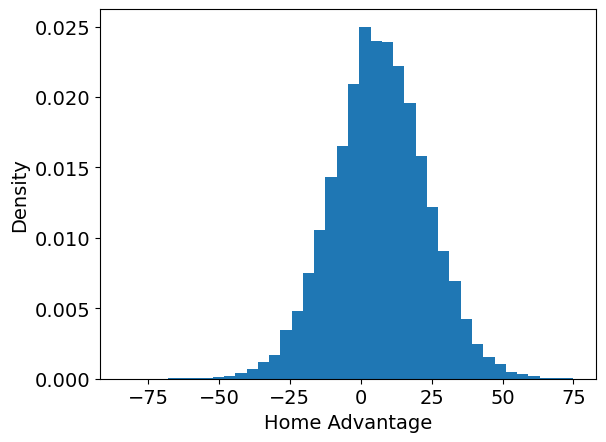

In [20]:
print(f"Mean Home Advantage = {np.mean(pair_games_df['home_advantage'])}")
plt.hist(pair_games_df['home_advantage'], bins=40, density=True)
plt.xlabel('Home Advantage')
plt.ylabel('Density')
plt.show()

**(3c).** [2 pts] Let $\mu_{HA}$ be the mean advantage. State your null and alternative hypotheses in math and in words. Please define "home court advantage" in the context of this test instead of using those exact words.

**A:** Null Hypothesis H0: 𝜇𝐻𝐴 = 0
Alternative Hypothesis H1: 𝜇𝐻𝐴 > 0

The null hypothesis states that the mean home advantage is zero. The alternative hypothesis states that the mean home advantage is greater than zero.

**(3d).** [3 pts] Assuming the game pairs are independent, run a 1-sided t-test to assess whether the mean home advantage is significantly above 0. Print the t-statistic and p-value. Interpret your result.

Hint: You may find `scipy.stats.ttest_1samp` useful.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html

In [21]:
t_statistic, p_value = stats.ttest_1samp(pair_games_df['home_advantage'], 0, alternative='greater')

print(f"t-statistic: {t_statistic:.3f}")
print(f"p-value: {p_value:.3f}")

t-statistic: 58.818
p-value: 0.000


**A:** The p-value is very small, indicating strong evidence against the null hypothesis that the mean home advantage is zero. We can interpret this result to mean that there is a statistically significant home court advantage in the NBA, and that teams are more likely to win when playing at their home stadium or arena.

**(3e).** [2 pts] The one-sample t-test you just ran makes the following 2 assumptions:

1. The mean home advantage is Normally distributed.
2. The home advantages from all the game pairs are independent and identically distributed.

Do these 2 assumptions hold?

**A:** Based on the histogram of home advantages it seems reasonable to assume the mean home advantage is normally distributed. The home advantages from all pairs aren't necessarily independent because for example the home_advantage between team i and team j within consecutive seasons are likely to be similar if the teams haven't changed much. They also aren't identically distributed because the skill difference between different pairs of teams isn't constant.

## 4. Weekend vs weekday

We will use the NBA dataset to assess whether the total number of points scored is different in weekend vs weekday games. Some people believe more points are scored on the weekend because players are more well-supported by packed audiences on the weekend. On the other hand, some people believe that because players take more time off the weekend, they are more focused and in shape on weekdays, so they might score more points on weekdays.

In this section, we will run a two-sided two-sample t-test. You may assume the two samples $X$ and $Y$ have equal variance. The t-statistic is 

\begin{equation}
    t = \frac{\left(\bar{X} - \bar{Y}\right) - \left(\mu_X - \mu_Y\right)}{s \sqrt{\frac{1}{n_X} + \frac{1}{n_Y}}}
\end{equation}

where $s^2$ is the pooled sample variance:

\begin{equation}
    s^2 = \frac{\left(n_X - 1\right) s_X^2 + \left(n_Y - 1\right) s_Y^2}{\left(n_X - 1\right) + \left(n_Y - 1\right)}
\end{equation}

$n_X$ and $n_Y$ are the numbers of samples, and $s_X^2$ and $s_Y^2$ are the empirical variances.

**(4a).** [1 pt] Create two subsets `df_weekend` and `df_weekday` of games played on weekends/weekdays, respectively.

In [22]:
df_weekend = df_millenial_subset.query('weekend == 1')
df_weekday = df_millenial_subset.query('weekend == 0')

**(4b).** [1 pt] What are average total scores for weekend vs weekday games? Print both.

In [23]:
print(f"Weekend Average = {np.mean(df_weekend['total_score'])}")
print(f"Weekday Average = {np.mean(df_weekday['total_score'])}")

Weekend Average = 196.4405616224649
Weekday Average = 196.9075830797685


**(4c).** [1 pt] What are the standard deviations of the total scores for weekend vs weekday games? Print both. Can we say variance is equal between these two samples?

In [24]:
print(f"Weekend Standard Deviation = {np.std(df_weekend['total_score'])}")
print(f"Weekday Standard Deviation = {np.std(df_weekday['total_score'])}")

Weekend Standard Deviation = 20.757269853973206
Weekday Standard Deviation = 20.76322756721499


**A:** (Type your answer here)

**(4d).** [2 pts] Plot a histogram of the densities of the total scores in games played on weekends and weekdays.

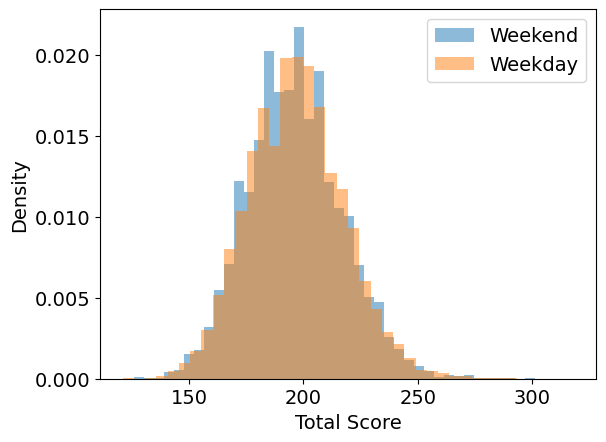

In [25]:
plt.hist(df_weekend['total_score'], bins=40, alpha=0.5, label='Weekend', density=True)
plt.hist(df_weekday['total_score'], bins=40, alpha=0.5, label='Weekday', density=True)
plt.xlabel('Total Score')
plt.ylabel('Density')
plt.legend()
plt.show()

**(4e).** [2 pts] Let $\mu_0$ and $\mu_1$ be the mean of total scores on the weekdays and weekends, respectively. State your null and alternative hypotheses in math and words.

**A:** Null hypothesis: The mean total score for games played on weekends is equal to the mean total score for games played on weekdays.𝜇0=𝜇1

Alternative hypothesis: The mean total score for games played on weekends is significantly different from the mean total score for games played on weekdays.𝜇0!=𝜇1

**(4f).** [3 pts] Assume the total scores from each game are independent and identically distributed. Run the t-test for your hypotheses. Print the t-statistic and p-value. What would you conclude?

*Hint:* You may use the `ttest_ind` function in `scipy.stats`

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [26]:
# extract total scores for weekend and weekday games
weekend_scores = df_weekend['total_score']
weekday_scores = df_weekday['total_score']

# perform two-sided t-test
t_statistic, p_value = stats.ttest_ind(weekend_scores, weekday_scores)

print(f"t-statistic = {t_statistic:.3f}, p-value = {p_value:.3f}")

t-statistic = -1.532, p-value = 0.126


**A:** The p-value is relatively large (greater than 0.05), which means that we cannot reject the null hypothesis that there is no difference between the mean total scores of weekend and weekday games at a significance level of 5%. In other words, we do not have enough evidence to conclude that the mean total scores are different between these two types of games.

Note: Although we assumed the total scores from each game are independent and identically distributed, this does not necessarily hold. For instance, in the next part, we will see how games with Michael Jordan might tend to have higher scores!

## 5. The Michael Jordan Effect

Widely regarded as the all-time greatest players in the history of the NBA, Michael Jordan led the Chicago Bulls to six championships (1991-93 and 1996-98). The other constants during the 1991-1998 Bulls era were hall of famer Scottie Pipen and coach Phil Jackson. We would like to study whether Jordan's presence on the team was (statistically) significant in bringing the championships to the Bulls.

Conveniently (for us), Jordan retired from basketball after winning three consecutive NBA championships with the Chicago Bulls. He retired ahead of the 1994 season but returned back from retirement late during the 1995 season to eventually lead the Bulls to three more titles in the 1996, 1997, 1998 seasons.

During his absence, both Pipen and Jackson were still at the Bulls, allowing us to study the impact of Michael Jordan's absence on the Chicago Bulls' performance. This fact will allow us to assume that the only change in the years with or without Jordan in the period 1992-1997 was Michael Jordan's presence/absence. You may assume there are no other confounding factors at play.

**(5a).** [2 pts] Produce a subset of the data which includes the following seasons only: 1992-1997. Additionally, the subset should only include games (home or away) featuring the Chicago Bulls.

In [27]:
bulls_df = df.query("season >= 1992 & season <= 1997 & (home_team == 'Chicago Bulls' or away_team == 'Chicago Bulls')")
print(bulls_df.head(5))

       season       date  home_pt        home_team  away_pt  \
28222    1992 1991-11-01      110    Chicago Bulls       90   
28241    1992 1991-11-02      109  Milwaukee Bucks      107   
28247    1992 1991-11-05      110    Chicago Bulls      118   
28258    1992 1991-11-06      113   Boston Celtics      132   
28274    1992 1991-11-08      108    Chicago Bulls       92   

                   away_team finished_in  winner_pt  margin  total_score  \
28222     Philadelphia 76ers  regulation        110      20          200   
28241          Chicago Bulls  regulation        109       2          216   
28247  Golden State Warriors  regulation        118       8          228   
28258          Chicago Bulls  regulation        132      19          245   
28274       Dallas Mavericks  regulation        108      16          200   

       day_of_week  weekend  
28222            4        0  
28241            5        1  
28247            1        0  
28258            2        0  
28274         

**(5b).** [3 pts] Create three new columns on the subset as follows: <br>
1. `for_score`: points scored by the Chicago Bulls (home or away) in the seasons 1992-1997. <br>
2. `against_score`: points scored against the Chicago Bulls (home or away) in the seasons 1992-1997. <br>
3. `net_score`: net score by the Chicago Bulls (home or away) in the seasons 1992-1997.

Your amended dataframe should pass the tests below.

In [28]:
#use indicators to extract bulls and opponents' score
bulls_df['for_score'] = (df['home_team']=='Chicago Bulls')*df['home_pt']+(df['away_team']=='Chicago Bulls')*df['away_pt']
bulls_df['against_score'] = (df['home_team']!='Chicago Bulls')*df['home_pt']+(df['away_team']!='Chicago Bulls')*df['away_pt']
bulls_df['net_score'] = bulls_df['for_score']-bulls_df['against_score']
print(bulls_df.head(5))

       season       date  home_pt        home_team  away_pt  \
28222    1992 1991-11-01      110    Chicago Bulls       90   
28241    1992 1991-11-02      109  Milwaukee Bucks      107   
28247    1992 1991-11-05      110    Chicago Bulls      118   
28258    1992 1991-11-06      113   Boston Celtics      132   
28274    1992 1991-11-08      108    Chicago Bulls       92   

                   away_team finished_in  winner_pt  margin  total_score  \
28222     Philadelphia 76ers  regulation        110      20          200   
28241          Chicago Bulls  regulation        109       2          216   
28247  Golden State Warriors  regulation        118       8          228   
28258          Chicago Bulls  regulation        132      19          245   
28274       Dallas Mavericks  regulation        108      16          200   

       day_of_week  weekend  for_score  against_score  net_score  
28222            4        0        110             90         20  
28241            5        1   

In [29]:
test_game = bulls_df.loc[bulls_df['date'] == pd.to_datetime('1997-06-13')]
assert test_game.for_score.values[0] == 90
assert test_game.against_score.values[0] == 86
assert test_game.net_score.values[0] == 4

**(5c).** [1 pt] Using the subset above, produce two disjoint subsets as follows: <br> 
`df_subset_jordan`: includes seasons 1992, 1993, 1996, 1997 (we leave 1994 and 1995 out). <br>
`df_subset_no_jordan`: includes seasons 1994, 1995 only.

In [30]:
df_subset_jordan = bulls_df.query('season < 1994 | season > 1995')
df_subset_no_jordan = bulls_df.query('season == 1994 | season == 1995')

**(5d).** [2 pts] Let $\mu_1$ be the means of `for_score` for the Chicago bulls during the Jordan seasons ('92, '93, '96, '97). Let $\mu_0$ be the means of `for_score` for the Chicago bulls during the seasons without him ('94, '95). What are the null and alternate hypotheses if we want to assess the Michael Jordan effect on `for_score` in these two time periods? Please state in math and in words.

**A:** Null Hypothesis: There is no difference in mean for_score during the Jordan seasons and seasons without him.
Alternate Hypothesis: There is a difference in mean for_score during the Jordan seasons and seasons without him.

H0: 𝜇0 = 𝜇1
Ha: 𝜇0 ≠ 𝜇1

**(5e).** [1 pt] Produce the mean `for_score` by the Chicago Bulls during the Jordan seasons and the seasons without him. Print both.

In [31]:
mean_for_score_jordan = df_subset_jordan['for_score'].mean()
mean_for_score_no_jordan = df_subset_no_jordan['for_score'].mean()

print("Mean for_score during the Jordan seasons:", mean_for_score_jordan)
print("Mean for_score during seasons without Jordan:", mean_for_score_no_jordan)

Mean for_score during the Jordan seasons: 104.39162561576354
Mean for_score during seasons without Jordan: 99.33695652173913


**(5f).** [2 pts] Conduct a two-sample t-test for differences between the `for_score` during the Michael Jordan seasons and seasons without him. Feel free to use the `scipy.stats` library to perform the t-test for independent samples and assume equal variances. Print the t-statistic and the associated p-value.

In [32]:
jordan_for_score = df_subset_jordan['for_score']
no_jordan_for_score = df_subset_no_jordan['for_score']

t_stat, p_val = stats.ttest_ind(jordan_for_score, no_jordan_for_score, equal_var=True)
print("T-statistic for for_score:", t_stat)
print("P-value for for_score:", p_val)

T-statistic for for_score: 4.756150092729335
P-value for for_score: 2.4852089514923217e-06


**(5g).** [3 pts] Repeat 5e and 5f for the `against_score`. Print the t-statistic and the associated p-value.

In [33]:
mean_against_score_jordan = df_subset_jordan['against_score'].mean()
mean_against_score_no_jordan = df_subset_no_jordan['against_score'].mean()

print("Mean against_score during the Jordan seasons:", mean_against_score_jordan)
print("Mean against_score during seasons without Jordan:", mean_against_score_no_jordan)

jordan_against_score = df_subset_jordan['against_score']
no_jordan_against_score = df_subset_no_jordan['against_score']

t_stat, p_val = stats.ttest_ind(jordan_against_score, no_jordan_against_score, equal_var=True)
print("T-statistic for against_score:", t_stat)
print("P-value for against_score:", p_val)

Mean against_score during the Jordan seasons: 95.02216748768473
Mean against_score during seasons without Jordan: 95.60326086956522
T-statistic for against_score: -0.5878270595434669
P-value for against_score: 0.5568740583479378


**(5h).** [2 pts] What would you conclude based on the two tests?

**A:** Based on the two tests, we can conclude that the Michael Jordan effect was significant for the for_score, as the p-value was less than 0.05, and we reject the null hypothesis. However, the effect was not significant for the against_score, as the p-value was greater than 0.05, and we fail to reject the null hypothesis.

**(5i).** [3 pts] Repeat 5e and 5f for the `net_score`. Print the t-statistic and the associated p-value.

In [34]:
mean_net_score_jordan = df_subset_jordan['net_score'].mean()
mean_net_score_no_jordan = df_subset_no_jordan['net_score'].mean()

print("Mean net_score during the Jordan seasons:", mean_net_score_jordan)
print("Mean net_score during seasons without Jordan:", mean_net_score_no_jordan)

jordan_net_score = df_subset_jordan['net_score']
no_jordan_net_score = df_subset_no_jordan['net_score']

t_stat, p_val = stats.ttest_ind(jordan_net_score, no_jordan_net_score, equal_var=True)
print("T-statistic for net_score:", t_stat)
print("P-value for net_score:", p_val)

Mean net_score during the Jordan seasons: 9.369458128078819
Mean net_score during seasons without Jordan: 3.733695652173913
T-statistic for net_score: 5.032968529925134
P-value for net_score: 6.428319460107873e-07


**(5j).** [1 pt] Does this test confirm the conclusion you reached based on the earlier two tests?

**A:** Yes. If he had no effect on against_score and a significant one on for_score then he also had a significant one on net_score since we could ignore against_score.

**(5k).** [2 pts] While Scottie Pippen and Phil Jackson were constants during the entire period 1992-1998, can you think of reasons to cast doubt on the conclusions reached by the tests?

*Hint:* We want you to question whether the assumption about "no other confounding variables" is valid? Could there be other factors at play?

**A:** The Bulls roster underwent changes other than simply Jordan retiring and unretiring and other key contributors such as BJ Horace Grant, Dennis Rodman, Toni Kukoc, etc. weren't present for the entire period. The rosters of other teams also were not constant so level of competition could alter the results as well.

## 6. Do back-to-back games impact scoring? (OPTIONAL: NOT FOR GRADE)
We want to test whether teams playing back-to-back games (i.e. playing on consecutive nights of the week) has any effect on total scoring during a game. 

**(6a).** Write a function, `rest_days()` which takes as input the complete dataset as a dataframe and adds a new column which records the total number of nights of rest that the home and away teams have had for each game. Call your function to update the dataframe.

*Note:* the column must track the <b>sum</b> of the rest days for the home and away team.

If a team has a prolonged rest (i.e. > 7 days), set that to 8 days. This will help eliminate the skewed effects of strikes and long periods off (e.g. the summer). The first game for a team can be set to 8 days as well. Therefore, the range for the new column is 2-16 days (both inclusive).

Your function should pass the test case below.

In [35]:
def rest_days(df):
    '''
    Add a column for the total number of rest days the home and away team have before a game
    @param df: pandas DataFrame, contains columns date, home_team, away_team, etc., will be modified by function
    @return: None
    '''
    last_game = {}
    for team in set(df['home_team']):
        last_game[team] = datetime.datetime(1900, 1, 1)
    rest_combinations = []
    
    for i in range(len(df)):
        game = df.loc[i]
        date = game['date']
        home = game['home_team']
        away = game['away_team']
        #calculate rest for each team
        home_rest = date-last_game[home]
        away_rest = date-last_game[away]
        #add them together
        rest_combinations.append(min(8, home_rest.days)+min(8, away_rest.days))
        #update last game played
        last_game[home] = date
        last_game[away] = date
    df['rest'] = rest_combinations
        
        
        

In [36]:
rest_days(df)
assert df.loc[np.logical_and.reduce((df['home_team'] == 'Boston Celtics',
                                     df['away_team'] == 'Miami Heat',
                                     df['date'] == pd.to_datetime('2017-03-26')))].rest.values[0] == 5

**(6b).** Produce a histogram of the rest days with 10 bins

col_0  count
rest        
0          1
2       7450
3      11550
4      22087
5       9248
6       5592
7       1643
8       1120
9        521
10       329
11       222
12       189
13        72
14        26
15         8
16       630


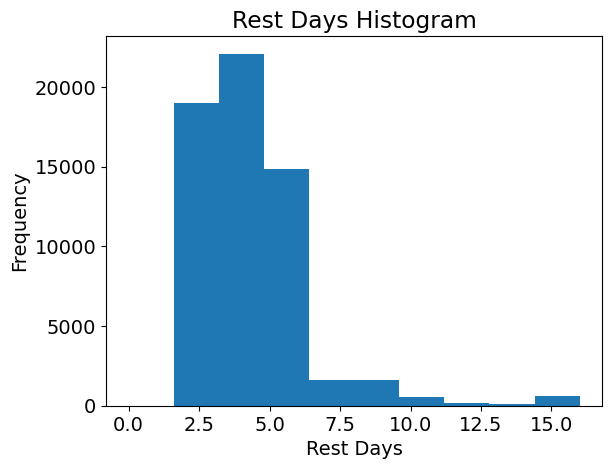

In [37]:
print(pd.crosstab(index=df["rest"], columns="count"))
plt.hist(df['rest'], bins=10)
plt.xlabel('Rest Days')
plt.ylabel('Frequency')
plt.title('Rest Days Histogram')
plt.show()

**(6c).** What does the histogram tell you about the schedule of an NBA team during the season?

**A:** The vast majority of games are played with a combined 3 or 4 day rest and it tails off rapidly as you increase the rest.

**(6d).** For the seasons 2000-2017 only, produce two subsets:<br>
`back_to_back`: with games where the rest days are <= 3 (i.e. at least one team is playing back-to-back)<br>
`longer`: games where the rest days are >=4 and <= 5.

In [38]:
back_to_back = df.query('season >= 2000 & season <= 2017 & rest <= 3')
longer = df.query('season >= 2000 & season <= 2017 & (rest == 4 | rest == 5)')


**(6e).** What would your Null Hypothesis be if you wanted to test whether back_to_back games produce different total scores than games with combined rest between 4-5 days? Assume there are no other confounding variables at play.

**A:** The null hypothesis would be that there is no significant difference in the total scores of games played by NBA teams with back-to-back games compared to games with combined rest between 4-5 days.

**(6f).** Print the mean total scores per game for the <b>back_to_back</b> and <b>longer</b> subsets (for seasons 2000-2017).

In [39]:
print("Mean total scores per game for back-to-back games: ", back_to_back['total_score'].mean())
print("Mean total scores per game for games with rest between 4-5 days: ", longer['total_score'].mean())

Mean total scores per game for back-to-back games:  196.54280821917808
Mean total scores per game for games with rest between 4-5 days:  197.18168168168168


**(6g).** For the seasons 2000-2017 and using the two subsets you created, conduct a two-sample t-test to test your hypothesis. Feel free to use the `scipy.stats` library to perform the t-test for independent samples with equal variances. Print the t-statistic and the associated p-value.

In [40]:
# Conduct t-test
t_stat, p_value = stats.ttest_ind(back_to_back['total_score'], longer['total_score'], equal_var=True)

# Print results
print("t-statistic: ", t_stat)
print("p-value: ", p_value)

t-statistic:  -2.02202130746823
p-value:  0.043187611133102294


**(6h).** What do you conclude about back-to-back games?

**A:** With a significance level of 0.05, we reject that there is no significant difference in the total scores of games played by NBA teams with back-to-back games compared to games with combined rest between 4-5 days.

**(6i).** Do you think the difference/no difference between <= 3 rest days and 4-5 rest days could be a result of confounding (i.e. other factors which may explain or be responsible for the observations)? What could be the confounding factors?

*Hint:* Think about situations during the season when the distributions of rest days could be different. 

**A:** Back-to-backs often involve the same matchup two days in a row or otherwise teams close to each other to minimize travel from either team. This means that the sample of matchups with back to backs is not drawn from the same distribution as longer rest. Also playoff matchups tend to involve 2-3 days of rest for each of team a lot of which would fall into the longer category again differentiating the sample distributions for the two datasets given the higher level of play in the playoffs.